In [88]:
from ortools.sat.python.cp_model import CpModel, CpSolver
from pysat.solvers import Solver as SATSolver
import gurobipy as gp
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import math

from typing import List, Set, Tuple, Iterable, Dict, Any, Optional

Node = Any
Edge = Tuple[Node, Node]

# Feedback Vertex Set
The *Feedback Vertex Set* (FVS) problem is a problem in graph theory. For a given graph G (directed or undirected) and a natural number k, this decision problem asks whether there exists a set of k vertices, whose removal would eliminate all cycles in G. In other words, it is to be determined whether a set of k vertices suffices to "cover" all cycles in G. This problem is proven to be NP-hard, which means that there exists no algorithm that can solve the problem on arbitrary graphs in polynomial time (unless P = NP).

The *Minimum FVS* problem asks for the smallest Feedback Vertex Set in G. Such a set can be found by solving the associated decision problem with different values for k (i.e. using binary search on k), until the smallest solution is found (feasible with k=x, infeasible with k=x-1).

In this example, the FVS decision problem is modeled as a Satisfiability (SAT) problem (including cardinality constraints).

In [89]:
def parse_graph_from_edgelist_file(path: str) -> nx.Graph:
    """
    A simple method for parsing an undirected graph from a list of edges in the following format:
    
    1-2
    1-5
    2-3
    3-4
    3-5
    """

    graph = nx.Graph()
    with open(path, "r") as f:
        for line in f.read().split():
            t = line.split("-")
            assert len(t) == 2
            p, q = t
            assert str(p).isdigit() and str(q).isdigit()
            graph.add_edge(p, q)
    return graph

### Load the test graph, draw it using a "nice" layout.

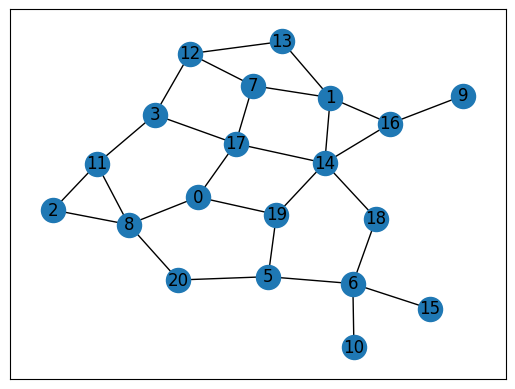

In [90]:
G = parse_graph_from_edgelist_file("graph1.edges")
nx.draw_networkx(G, pos=nx.layout.kamada_kawai_layout(G))

### Utility methods

In [91]:
def find_cycle(graph: nx.Graph) -> Optional[List[Node]]:
    """
    Tries to find a cycle in the given graph. If one is found, it is returned as a list of vertices. Otherwise, 'None' is returned.
    """
    try:
        cycle_edges = nx.find_cycle(graph)
        return [e[0] for e in cycle_edges]
    except:
        return None

def greedy_fvs(graph: nx.Graph):
    """
    This method generates a greedy solution to the Feedback Vertex Set problem.
    The algorithm iteratively identifies and "breaks open" remaining cycles in the graph.
    The utilized greedy strategy always removes the vertex with the highest degree from a found cycle, as the chance for breaking
    open more than one cycle increases.
    """
    graph = graph.copy()
    feedback_vertex_set = set()
    while (cycle := find_cycle(graph)) is not None:
        highest_degree_vertex = max(cycle, key=lambda v: graph.degree(v))
        graph.remove_node(highest_degree_vertex)
        feedback_vertex_set.add(highest_degree_vertex)
    return feedback_vertex_set

def visualize_fvs(graph: nx.Graph, feedback_vertex_set: Set[Node]):
    """
    Draws a before-after visualization of a given Feedback Vertex Set solution on a given graph.
    """
    layout = nx.layout.kamada_kawai_layout(graph)
    nx.draw_networkx(graph, pos=layout, node_color=["red" if p in feedback_vertex_set else "cyan" for p in G.nodes()])
    plt.show()
    _graph = graph.copy()
    _graph.remove_nodes_from(feedback_vertex_set)
    nx.draw_networkx(_graph, pos=layout, node_color="cyan")
    plt.show()


## Find a greedy solution

The greedy solution {'1', '6', '17', '8'} has size 4!


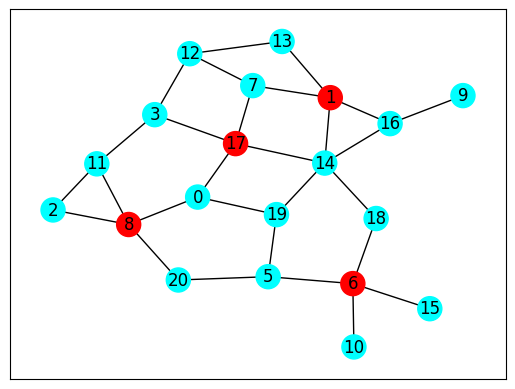

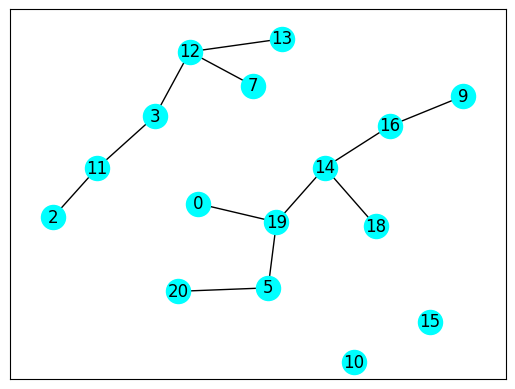

In [92]:
greedy_solution = greedy_fvs(G)
print(f"The greedy solution {greedy_solution} has size {len(greedy_solution)}!")
visualize_fvs(G, greedy_solution)

## Implement an exact solver using Cardinality SAT

In [93]:
class FeedbackVertexSetSolverSAT():
    def __init__(self, graph: nx.Graph) -> None:
        self.graph = graph
        self.node_variables: Dict[Node, int] = dict()
    
    def get_node_var(self, v: Node):
        """
        This method associates each vertex in the graph with an integer between 1 and |V|.
        These numbers represent the boolean variables in the clauses of the SAT problem.
        Using this method also potentially reduces the size of the resulting SAT problem, as only variables for vertices
        appearing in any cycle are generated. We may call this "lazy variable generation"
        """
        if not v in self.node_variables:
            self.node_variables[v] = len(self.node_variables) + 1
        return self.node_variables[v]
    
    def decide(self, k: int):
        """
        Decide, whether a feedback vertex set of (at most) k vertices exists.
        If one exists, it is returned as a set of vertices. Otherwise, 'None' is returned.

        This is done by modeling and solving a Cardinality-SAT instance.

        The constraints are as follows:
            - For every cycle, force at least one of the vertices to be "selected".
                - Note: Finding all (even simple) cycles in an undirected graph requires exponential time (otherwise, solving Hamiltonian Cycle and TSP would be easy), so we lazily introduce this constraint whenever a cycle remains after solving the problem.
            - Using a cardinality constraint, we allow at most k vertices to be "selected".
        """

        # Initialize our Cardinality-SAT solver
        solver = SATSolver("MiniCard")

        def constrain_cycle(cycle: List[Node]):
            """
            Force the inclusion of at least one vertex in the cycle into the FVS.
            """
            # fetch the variables associated with the vertices in the cycle
            cycle_vertex_vars = [self.get_node_var(v) for v in cycle]
            # force at least one of them to be selected
            solver.add_clause(cycle_vertex_vars)
        
        def limit_positive_variables():
            """
            Limit number of "selected" vertices to k
            """
            all_node_vars = list(self.node_variables.values())
            solver.add_atmost(all_node_vars, k)
        
        # Initial constraints
        for cycle in nx.cycle_basis(self.graph):
            constrain_cycle(cycle)
        limit_positive_variables()
        
        # as long as the SAT solver returns "satisfiable"
        while solver.solve():
            # retrieve the solution from the solver. This solution contains a positive number for every positively assigned variable and a negative number for every negatively assigned one
            solution = set(solver.get_model())
            feedback_nodes = set(p for (p, var) in self.node_variables.items() if var in solution)
            subgraph = self.graph.copy()
            subgraph.remove_nodes_from(feedback_nodes)
            cycle = find_cycle(subgraph)
            if cycle:
                # Lazily add constraint to "forbid" the found cycle, solve again.
                # This is not as inefficient as you might think; The solver is able to (more or less) continue from where it stopped. In addition, fewer constraints usually result in much easier models and are solved way faster than "complete" models, in our case with an exponential number of constraints (for each existing cycle).
                num_vars_before_new_constraint = len(self.node_variables)
                constrain_cycle(cycle)
                if len(self.node_variables) != num_vars_before_new_constraint:
                    limit_positive_variables()
                continue
            else:
                # The remaining graph contains no cycles. A valid solution was found!
                print(f"k = {k}: SAT")
                return feedback_nodes
        else:
            # The SAT-solver proved the formula to be infeasible. This proves that there exists no FVS of size k.
            print(f"k = {k}: UNSAT")
            return None
    
    def find_optimum(self):
        """
        Finds the smallest FVS on the given graph.
        """

        # calculate a greedy FVS in order to obtain an upper bound to the minimum FVS
        solution = greedy_fvs(self.graph)
        k = len(solution)
        print(f"A greedy solution of size {k} was found!")

        while k >= 0 and (smaller_solution := self.decide(k - 1)) is not None:
            k -= 1
            solution = smaller_solution
            print(f"A solution of size {k} was found by the solver!")
        
        print(f"The solution of size {k} was proven to be optimal!")
        return solution


A greedy solution of size 4 was found!
k = 3: SAT
A solution of size 3 was found by the solver!
k = 2: UNSAT
The solution of size 3 was proven to be optimal!
{'14', '8', '12'}


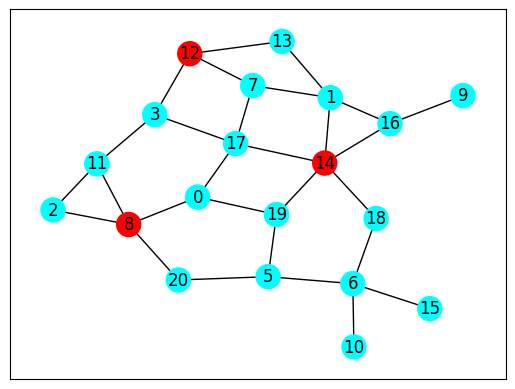

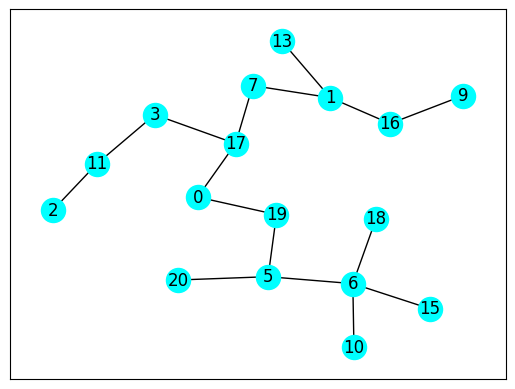

In [94]:
fbv_solver = FeedbackVertexSetSolverSAT(G)
feedback_nodes = fbv_solver.find_optimum()
print(feedback_nodes)
visualize_fvs(G, feedback_vertex_set=feedback_nodes)